In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import color
from skimage.filters import threshold_otsu
from skimage import filters
import glob

### Load dataset
We have two datasets we want. the first dataset consist of images that are skin samples with each image being an rgb with dimensions $35\times35$, this dataset has a total of $3\ 354$ images. The second dataset consist of images that are not skin samples with each image being an rgb image with dimensions $35\times35$. When the images are loaded they are converted from $RGB$ colourspace to $YCbCr$ colourspace. The motivation behind this is that in $YbCbCr$ colourspace the illumination component is only focused on a single component $Y$ while colour components are distributed over $Cb$ and $Cr$  components <br></br> the coversion formula is shown below. $$Y=0.299R+0.587G+0.11B$$ $$Cb=B-Y$$ $$Cr=R-Y$$

The $Y$ component is then dropped and only the $Cb$ and $Cr$ components are kept

In [2]:
def loadSkinImages(path):
    i=0
    D=np.zeros((3354*35*35,2))
    for filename in glob.glob(path+'/*.jpg'):
        im=plt.imread(filename)
        im=color.rgb2ycbcr(im)
        D[i:i+35*35,0]=im[:,:,1].flatten()
        D[i:i+35*35,1]=im[:,:,2].flatten()
        i=i+35*35
    return D

def loadNotSkinImages(path):
    i=0
    D=np.zeros((5590*35*35,2))
    for filename in glob.glob(path+'/*.jpg'): #assuming gif
        im=plt.imread(filename)
        im=color.rgb2ycbcr(im)
        D[i:i+35*35,0]=im[:,:,1].flatten()
        D[i:i+35*35,1]=im[:,:,2].flatten()
        i=i+35*35
    return D

In [3]:
#this matrix contains Cb and Cr values column wise from skin dataset
X=loadSkinImages("../data/skin-data")
#this matrix contains Cb and Cr values column wise from not skin dataset
XC=loadNotSkinImages("../data/not-skin-data")

### Dataset processing
We want to be able to extract the mean vector and covariance matrix from dataset

In [4]:
def getMean(data):
    return np.mean(data,axis=0)

def getStd(data):
    return np.std(data,axis=0)

def getCov(data):        
    cov=np.cov(data.T)
    return cov

### Thresholding method
To perfom skin segmentation using a thresholding approach we use the loaded skin samples dataset to obtain a mean vector that represent $Cb$ and $Cb$ colour components from the sample images, we also obtain the standard deviation of the $2$ components. In order to segment a new input image we compute the euclidean distance of the corresponding channels from the mean vector, we then use a scalar multiple the norm of the standard deviation vector as a threshold values say $T$. We then segment as follows
 $$ 
    im(x,y)=\begin{cases} 
      1 & if \ D(x,y)<T\\
      0 & otherwise\\
   \end{cases}
   $$
Before the thresholding process the image is smoothed using a gaussian filter where $\sigma=6$ in order to improve results.

In [5]:
def thresholdSegmentation(image):
    f=image.copy() 
    #image smoothing
    f=filters.gaussian(f,sigma=6,multichannel=True) 
    #rgb to ycbcr
    ycbcrImage=color.rgb2ycbcr(f)
    
    #extract relevant channels discard y
    cb=ycbcrImage[:,:,1]
    cr=ycbcrImage[:,:,2]
    
    #mean vector cb,cr and standard deviation from skin samples stored in X
    mean=getMean(X)
    std=1.4*getStd(X)
    
    #subtract mean value
    cb=cb-mean[0]
    cr=cr-mean[1]
    d=np.sqrt(cb**2+cr**2)
    t=np.sqrt(np.dot(std,std))
    
    result=np.zeros(cb.shape)
    
    #thresholding step
    idx=d<t
    result[idx]=1
    return result

### $K$-Means clustering
For skin segmentation using $k$ means clustering we treat the image as if there are only two objects in the image. These objects being human skin and any other object that is not human skin. Which means there are two clusters, $c_1$ human skin and $c_2$ not human skin. The initial cluster centers are set to be the mean vectors obtained from the skin samples and not skin samples. To obtain a binary image the following is done
 $$ 
    im(x,y)=\begin{cases} 
      1 & if \ im(x,y)\in c_1\\
      0 & if \ im(x,y)\in c_2\\
   \end{cases}
   $$
before $k$ means clustering is perfomed the image is smoothed using a gaussian filter with $\sigma=6$ 

In [6]:
def kMeans(image):
    f=image.copy()
    #image smoothing
    f=filters.gaussian(f,sigma=6,multichannel=True) 
    
    #rgb to ycbcr
    ycbcrImage=color.rgb2ycbcr(f)
    
    shape=image.shape
    c=np.zeros((shape[0],shape[1]))
    
    #initial cluster centroids
    c1=getMean(X)
    c2=getMean(XC)
    
    while True:
        cb=ycbcrImage[:,:,1]
        cr=ycbcrImage[:,:,2]
        d1=np.sqrt((cb-c1[0])**2+(cr-c1[1])**2)
        d2=np.sqrt((cb-c2[0])**2+(cr-c2[1])**2)
       
        n1=np.count_nonzero(d1<d2)
        n2=np.count_nonzero(d1>d2)
    
        idx=d1<d2
        idy=d1>d2
        
        p=c.copy()
        c[idx]=1
        c[idy]=0
        
        temp1=c1.copy()
        temp2=c2.copy()
        
        c1[0]=np.sum(cb[idx])
        c1[1]=np.sum(cr[idx])
        c1=c1/n1
        
        c2[0]=np.sum(cb[idy])
        c2[1]=np.sum(cr[idy])
        c2=c2/n2
        
        #residual error
        err=(np.sqrt(np.dot(temp1-c1,temp1-c1)))+(np.sqrt(np.dot(temp2-c2,temp2-c2)))
        
        #stopping criteria
        if err<1:
            return c
        
    return c


### Gaussian skin color model
Starting off with a colour image the goal is to obtain a skin-likelihood image that can then be thresholded to segment human skin pixels from non human skin pixels. We use the multivariate normal distribution to model distribution of the distribution of human skin pixels. The mean vector and covariance matrix are obtained from the skin samples in dataset. 
### $$p(x)=e^{-\frac{1}{2}(\boldsymbol x-\boldsymbol \mu)^T(\boldsymbol C^{-1})(\boldsymbol x-\boldsymbol \mu)}$$ 
where $\boldsymbol x=(cb,cr)^T$, $\mu=(\mu_{cb},\mu_{cr})$ and $\boldsymbol C$ is the covariance matrix. The input image is smoothed using a gaussian filter with $\sigma=6$ before any segmentation. The 

In [7]:
def gaussianSegmentation(image):
    f=image.copy()
    #image smoothing
    f=filters.gaussian(f,sigma=6,multichannel=True) 
    
    #rgb to ycbcr
    ycbcrImage=color.rgb2ycbcr(f)
    
    #stuff to compute probaility values
    shape=ycbcrImage.shape
    cb=ycbcrImage[:,:,1].flatten()
    cb=cb.reshape(len(cb),1)
    cr=ycbcrImage[:,:,2].flatten()
    cr=cr.reshape(len(cr),1)
    x=np.hstack((cb,cr))
    mean=getMean(X)
    cov=getCov(X)
    covInverse=np.linalg.inv(cov)
    x=x-mean
    y=x@covInverse
    z=np.sum(x*y,axis=1)
    p=np.exp(-0.5*z).reshape(shape[0],shape[1])
    
    #thresholding step
    thresh=filters.threshold_otsu(p)
    binary=p>thresh
    
    return binary


### Testing on Face Images
We apply the above skin detection methods on face images.

In [15]:
#display function for input and output immages
def display(mode,path):
    #save path
    save={"face-original/":"face-segmented","family-original/":"family-segmented"}
    
    if mode=="threshold":
        names=[i for i in range(1,4)]
        fig,axis=plt.subplots(3,2,figsize=(12,12))
        fig.suptitle("Original vs Thresholding skin segmentation")
        for i in range(3):
            for j in range(2):
                image=plt.imread("../data/"+path+str(names[i])+".jpg")
                binary=thresholdSegmentation(image)
                plt.imsave("../data/"+save[path]+"/"+str(names[i])+".jpg",binary,cmap="gray")
                axis[i,j].imshow(binary,cmap="gray")
            axis[i,0].imshow(image)
        plt.savefig("threshold.png")
    
    elif mode=="cluster":
        names=[i for i in range(4,7)]
        fig,axis=plt.subplots(3,2,figsize=(12,12))
        fig.suptitle("Original vs K-means clustering skin segmentation")
        for i in range(3):
            for j in range(2):
                image=plt.imread("../data/"+path+str(names[i])+".jpg")
                binary=kMeans(image)
                plt.imsave("../data/"+save[path]+"/"+str(names[i])+".jpg",binary,cmap="gray")
                axis[i,j].imshow(binary,cmap="gray")
            axis[i,0].imshow(image)
        plt.savefig("clustering.png")
    
    elif mode=="gaussian":
        names=[i for i in range(7,10)]
        fig,axis=plt.subplots(3,2,figsize=(12,12))
        fig.suptitle("Original vs Gaussian skin color model segmentation")
        for i in range(3):
            for j in range(2):
                image=plt.imread("../data/"+path+str(names[i])+".jpg")
                binary=gaussianSegmentation(image)
                plt.imsave("../data/"+save[path]+"/"+str(names[i])+".jpg",binary,cmap="gray")
                axis[i,j].imshow(binary,cmap="gray")
            axis[i,0].imshow(image)
        plt.savefig("gaussian.png")
    

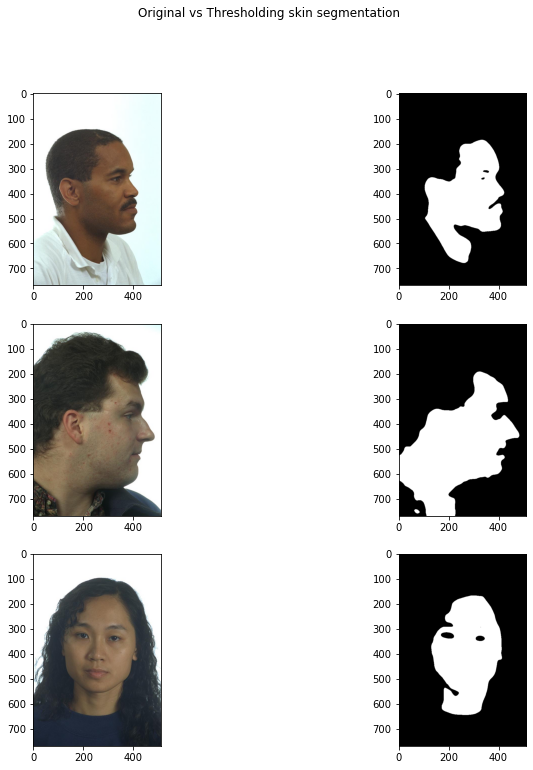

In [17]:
display("threshold","face-original/")

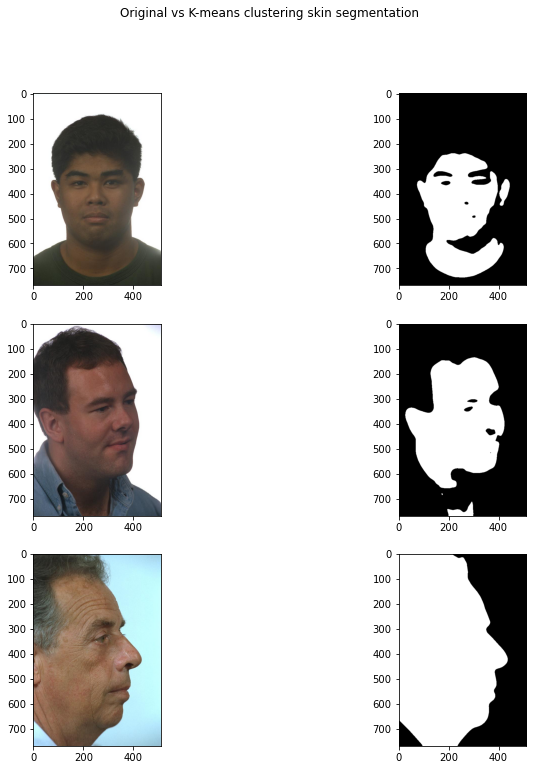

In [18]:
display("cluster","face-original/")

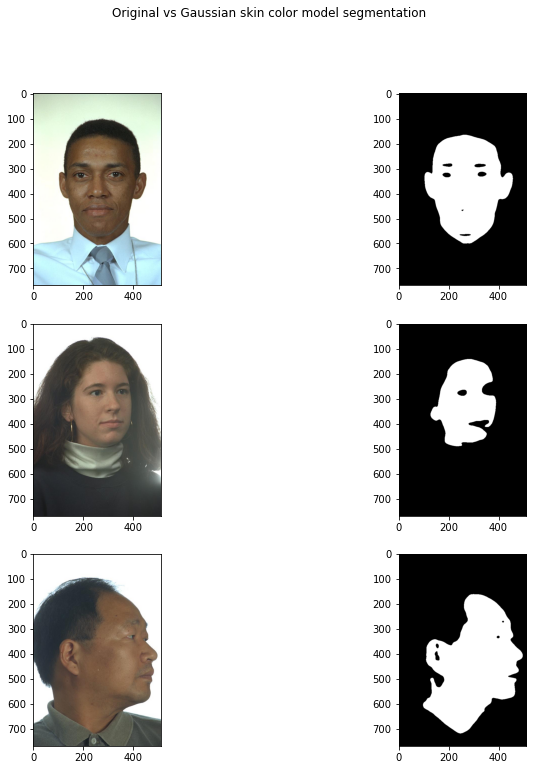

In [19]:
display("gaussian","face-original/")

### Testing on Family photos
We apply the above skin detection methods on family images.

In [ ]:
display("threshold","family-original/")

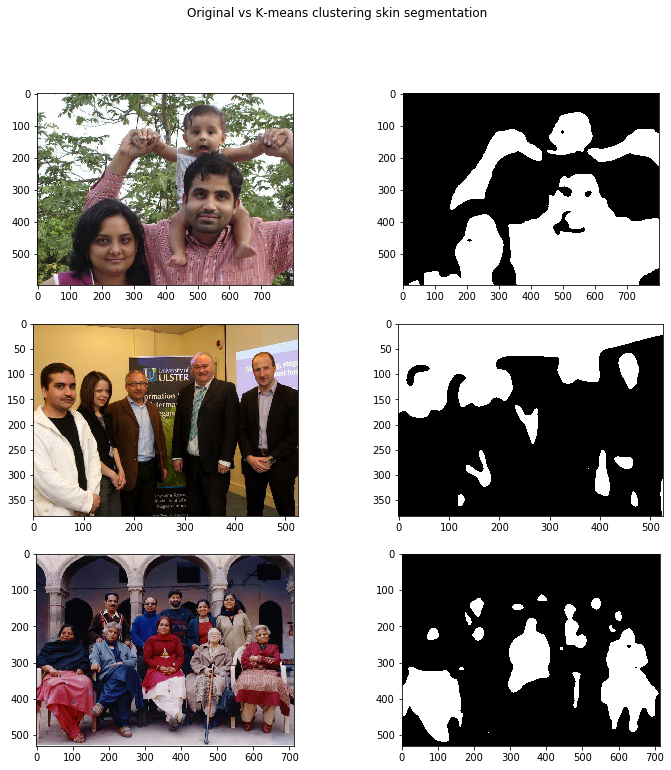

In [24]:
display("cluster","family-original/")

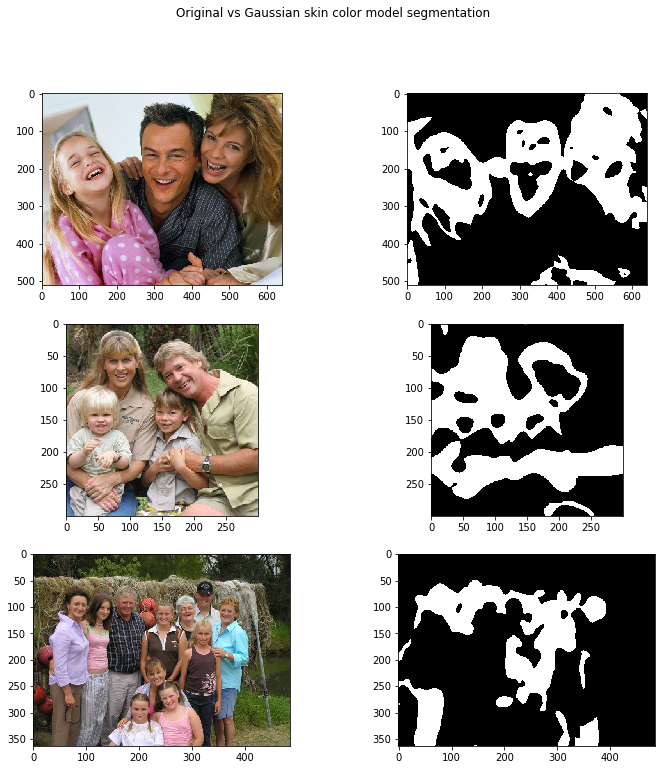

In [25]:
display("gaussian","family-original/")

### Saving output images
From the resulting images above, the thresholding skin segmentation algorithm seems to produce better results than the clustering and gaussian model in both face images and family images. The above algorithms display adequate perfomance for face images while they do not perfom well on family images. All ouput images that are saved were obtained using the thresholding approach. 

In [26]:
def saveImages():
    #save face images
    for i in range(1,21):
        image=plt.imread("../data/face-original/"+str(i)+".jpg")
        binary=thresholdSegmentation(image)
        plt.imsave("../data/face-segmented/"+str(i)+".jpg",binary,cmap="gray")

    #save family photos
    for i in range(1,11):
        image=plt.imread("../data/family-original/"+str(i)+".jpg")
        binary=thresholdSegmentation(image)
        plt.imsave("../data/family-segmented/"+str(i)+".jpg",binary,cmap="gray")
        
saveImages()